First, we install the [flow-stability](https://github.com/alexbovet/flow_stability) package:

In [ ]:
!pip install sparse_dot_mkl  # this is optional
!pip install git+https://github.com/alexbovet/flow_stability.git

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from flow_stability.SynthTempNetwork import Individual, SynthTempNetwork
from flow_stability.TemporalNetwork import ContTempNetwork
from flow_stability.FlowStability import FlowIntegralClustering

MKL_INT_NUMPY <class 'numpy.int32'>


# Example of temporal network with asymmetric temporal paths (Fig. 2)


In [2]:
inter_tau = 1
activ_tau = 1
t_start = 0
n_groups = 3
n_per_group = 9
individuals = []


m1=0.95
p1=0.95
deltat1 =120
deltat2=40

t_end = 3*deltat1+2*deltat2




def make_step_block_probs(deltat1, deltat2, m1=1, p1=1):
    """ Returns a function that generate the block probability matrix as a function of time.
    
        `deltat1` is the length of the within step
    
        `deltat2` is the length of the echanging step
        
        `m1` is the prob of self-interaction (during deltat1)
        
        `p1` is the prob of cross-interaction (during deltat2)
    """


    def block_mod_func(t):
        
        m2 = (1-m1)/2
        p2 = (1-p1)
        
        ex12 = np.array([[p2,p1,0],
                         [p1,p2,0],
                         [0,0,1]])
        ex23 = np.array([[1,0,0],
                         [0,p2,p1],
                         [0,p1,p2]])
        ex13 = np.array([[p2,0,p1],
                         [0, 1, 0],
                         [p1,0,p2]])
    
        I = np.array([[m1,m2,m2],
                      [m2,m1,m2],
                      [m2,m2,m1]])
        if t>=0 and  t < deltat1:
            return ex12
        elif t>=deltat1 and t<deltat1+deltat2:
            return I
        elif t>=deltat1+deltat2 and t < 2*deltat1+deltat2:
            return ex23
        elif t>= 2*deltat1+deltat2 and t < 2*(deltat1+deltat2):
            return I
        elif t>= 2*(deltat1+deltat2) and t < 2*(deltat1+deltat2)+deltat1:
            return ex13
        else:
            print('Warning : t must be >=0 and <= 3*deltat1+2*deltat2' +\
                  't is ', t)
            return I
        
    return block_mod_func
 


block_prob_mod_func = make_step_block_probs(deltat1,deltat2,m1,p1)


In [3]:
# create agents for the simlation
for g in range(n_groups):

    individuals.extend([Individual(i, inter_distro_scale=inter_tau,
                                      activ_distro_scale=activ_tau,
                                      group=g) for i in range(g*n_per_group,(g+1)*n_per_group)])

In [4]:
# run simulation
sim = SynthTempNetwork(individuals=individuals, t_start=t_start, t_end=t_end,
                       next_event_method='block_probs_mod',
                       block_prob_mod_func=block_prob_mod_func)

print('running simulation')
t0 = time.time()
sim.run(save_all_states=True, save_dt_states=True, verbose=False)
print(f'done in {time.time()-t0:.2f}s')


running simulation
done in 9.96s


## Creating a continuous time temporal network

In [5]:
# creating a temporal network from the simulation's result
net = ContTempNetwork(source_nodes=sim.indiv_sources,
                      target_nodes=sim.indiv_targets,
                      starting_times=sim.start_times,
                      ending_times=sim.end_times,
                      merge_overlapping_events=True)

PID  886145  :  merged  1393  events
PID  886145  :  merged  0  events


In [6]:
# the events of the temporal network are saved in a pandas dataframe in net.events_table
net.events_table

,source_nodes,target_nodes,starting_times,ending_times,durations
0,22,26,0.065599,0.841499,0.775900
1,10,7,0.075797,0.952079,0.876283
2,16,7,0.087016,0.435586,0.829681
3,17,4,0.119418,0.549631,0.430213
4,18,20,0.219895,0.269274,0.049379
...,...,...,...,...,...
10643,4,20,439.543456,439.913576,0.370120
10644,8,23,439.549984,439.871138,0.321153
10645,13,9,439.651820,439.723903,0.072083
10646,14,16,439.655587,439.897924,0.242337


In [7]:
# all the event times (starts and ends) are saved in 
net.times

Index([0.06559890137426386, 0.07579668878612185, 0.08701627729006729,
       0.11941796661031288, 0.21989547405409668, 0.26011635770561836,
         0.269274132085786,  0.3760668476779875,  0.3870636171122127,
       0.39518872652772347,
       ...
         439.8394231922225,  439.85301336351387,   439.8711377515593,
         439.8979235268881,   439.9135759349502,  439.92238479038343,
         439.9501641799652,  439.95158184045937,   439.9649303382711,
        439.99630207484034],
      dtype='float64', name='times', length=21296)

In [8]:
# Compute inter transition matrices. 
# lamda is random walk rate.
# By default, the matrix exponential is computed using the version of the algorithm for dense matrices (scipy expm), 
# which is faster but only works for small networks. 
# To use the sparse implementation, set `dense_expm=False`

lamda=1/10
t0 = time.time()
net.compute_inter_transition_matrices(lamda=lamda, verbose=True)
print(f'done in {time.time()-t0:.2f}s')

PID  886145  :  Computing Laplacians
PID  886145  :  0  over  21295
PID 886145 : 0.01s
PID  886145  :  1000  over  21295
PID 886145 : 1.25s
PID  886145  :  2000  over  21295
PID 886145 : 2.48s
PID  886145  :  3000  over  21295
PID 886145 : 3.79s
PID  886145  :  4000  over  21295
PID 886145 : 5.06s
PID  886145  :  5000  over  21295
PID 886145 : 6.37s
PID  886145  :  6000  over  21295
PID 886145 : 7.61s
PID  886145  :  7000  over  21295
PID 886145 : 8.95s
PID  886145  :  8000  over  21295
PID 886145 : 10.22s
PID  886145  :  9000  over  21295
PID 886145 : 11.42s
PID  886145  :  10000  over  21295
PID 886145 : 12.66s
PID  886145  :  11000  over  21295
PID 886145 : 13.99s
PID  886145  :  12000  over  21295
PID 886145 : 15.29s
PID  886145  :  13000  over  21295
PID 886145 : 16.56s
PID  886145  :  14000  over  21295
PID 886145 : 17.87s
PID  886145  :  15000  over  21295
PID 886145 : 19.09s
PID  886145  :  16000  over  21295
PID 886145 : 20.39s
PID  886145  :  17000  over  21295
PID 886145 : 2

In [9]:
# the matrices are saved in a list here
net.inter_T[lamda]
# where net.inter_T[lamda][k] is the probability transition matrix
# between net.times[k] and net.times[k+1]

[<27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 29 stored elements in Compressed Sparse Row format>,
 <27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 31 stored elements in Compressed Sparse Row format>,
 <27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 35 stored elements in Compressed Sparse Row format>,
 <27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 37 stored elements in Compressed Sparse Row format>,
 <27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 39 stored elements in Compressed Sparse Row format>,
 <27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 43 stored elements in Compressed Sparse Row format>,
 <27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 39 stored elements in Compressed Sparse Row format>,
 <27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 41 stored elements in Compressed Sparse Row format>,
 <27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 45 stored

In [10]:
# the temporal network can be saved, togheter with the inter-event transition matrices in a pickle file:
net.save('example_network')


In [11]:
# and can be loaded unsing `ContTempNetwork.load`
net2 = ContTempNetwork.load('example_network')


## Computing the covariance integral

In [12]:
# We can now compute the integral of the covariance using FlowIntegralClustering.
# We need to give the inter-event transition matrices, the inter-event times and 
# a list of times until which to compute the integral is computed.

integral_time_grid = np.linspace(0, t_end, 12, endpoint=True)

I_forw = FlowIntegralClustering(T_inter_list=[T.toarray() for T in net.inter_T[lamda]], 
                                time_list=net.times,
                                integral_time_grid=integral_time_grid,
                                verbose=True)

PID  886145  : computing T_list
PID  886145  : computing integral
PID  886145  :  0  over  21295  took 0.00s
PID  886145  :  1000  over  21295  took 0.04s
PID  886145  :  2000  over  21295  took 0.04s
PID  886145  :  3000  over  21295  took 0.03s
PID  886145  :  4000  over  21295  took 0.03s
PID  886145  :  5000  over  21295  took 0.03s
PID  886145  :  6000  over  21295  took 0.03s
PID  886145  :  7000  over  21295  took 0.04s
PID  886145  :  8000  over  21295  took 0.03s
PID  886145  :  9000  over  21295  took 0.03s
PID  886145  :  10000  over  21295  took 0.03s
PID  886145  :  11000  over  21295  took 0.03s
PID  886145  :  12000  over  21295  took 0.03s
PID  886145  :  13000  over  21295  took 0.03s
PID  886145  :  14000  over  21295  took 0.03s
PID  886145  :  15000  over  21295  took 0.04s
PID  886145  :  16000  over  21295  took 0.03s
PID  886145  :  17000  over  21295  took 0.03s
PID  886145  :  18000  over  21295  took 0.04s
PID  886145  :  19000  over  21295  took 0.03s
PID  88

In [13]:
# The list of transition matrices are stored in I_forw.T_list
# where I_forw.T_list[k] contains the transition matrix between net.times[0] and net.times[k+1]

I_forw.T_list[10]

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00

In [14]:
# The autocovariance integrals are stored in I_forw.I_list
# I_forw.I_list[k] contains the integral of the autocovariance 
# from I_forw._t_integral_grid[0] to I_forw._t_integral_grid[k+1]

I_forw.I_list[3]

array([[ 0.00187848,  0.00046445,  0.00047818,  0.00049177,  0.0005152 ,
         0.00054111,  0.00067951,  0.00050399,  0.00058956,  0.00053274,
         0.00049916,  0.00045511,  0.00052095,  0.00058123,  0.0005581 ,
         0.00072395,  0.00054754,  0.00095728, -0.00127981, -0.00127981,
        -0.00127981, -0.00127981, -0.00127981, -0.00127982, -0.00127981,
        -0.00127981, -0.00127981],
       [ 0.00046445,  0.00227814,  0.00051547,  0.00050436,  0.00048619,
         0.00048035,  0.00049403,  0.00048188,  0.00049479,  0.00072627,
         0.00057059,  0.00089986,  0.00062647,  0.000583  ,  0.00051353,
         0.00049842,  0.00044337,  0.00045717, -0.00127982, -0.00127982,
        -0.00127982, -0.00127982, -0.00127982, -0.00127982, -0.00127982,
        -0.00127982, -0.00127982],
       [ 0.00047818,  0.00051547,  0.00216304,  0.00053719,  0.00049316,
         0.00055626,  0.00049824,  0.00051882,  0.00049354,  0.00047198,
         0.00076343,  0.00058384,  0.00078871,  0.0005

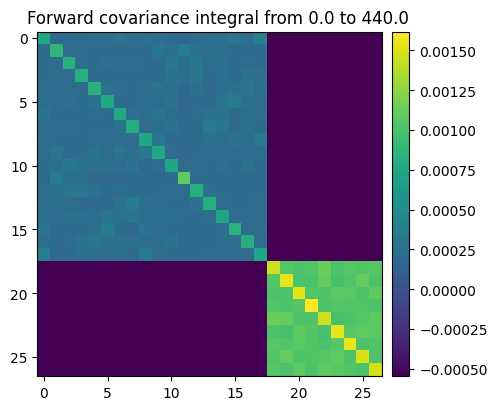

In [15]:
plt.matshow(I_forw.I_list[10])
ax = plt.gca()
adivider = make_axes_locatable(ax)
cax = adivider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(cax=cax)
ax.xaxis.tick_bottom()
_ =  plt.title(f'Forward covariance integral from {I_forw.integral_time_grid[0]} to {I_forw.integral_time_grid[11]}',
               loc='right')


In [16]:
# similarly, we can compute the backward covariance integral, by reversing time.
I_back = FlowIntegralClustering(T_inter_list=[T.toarray() for T in net.inter_T[lamda]], 
                                time_list=net.times,
                                integral_time_grid=integral_time_grid,
                                reverse_time=True,
                                verbose=True)

PID  886145  : computing T_list
PID  886145  : computing integral
PID  886145  :  0  over  21295  took 0.00s
PID  886145  :  1000  over  21295  took 0.04s
PID  886145  :  2000  over  21295  took 0.04s
PID  886145  :  3000  over  21295  took 0.04s
PID  886145  :  4000  over  21295  took 0.04s
PID  886145  :  5000  over  21295  took 0.04s
PID  886145  :  6000  over  21295  took 0.04s
PID  886145  :  7000  over  21295  took 0.04s
PID  886145  :  8000  over  21295  took 0.04s
PID  886145  :  9000  over  21295  took 0.04s
PID  886145  :  10000  over  21295  took 0.04s
PID  886145  :  11000  over  21295  took 0.04s
PID  886145  :  12000  over  21295  took 0.04s
PID  886145  :  13000  over  21295  took 0.03s
PID  886145  :  14000  over  21295  took 0.03s
PID  886145  :  15000  over  21295  took 0.03s
PID  886145  :  16000  over  21295  took 0.03s
PID  886145  :  17000  over  21295  took 0.03s
PID  886145  :  18000  over  21295  took 0.03s
PID  886145  :  19000  over  21295  took 0.03s
PID  88

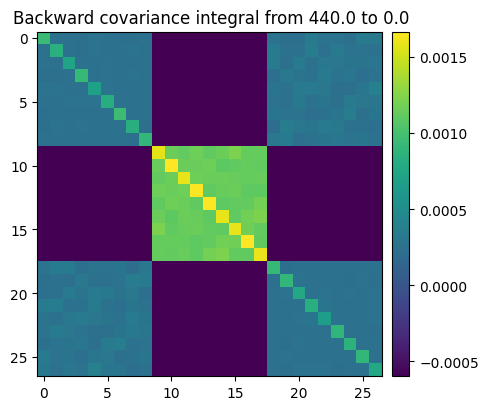

In [17]:
plt.matshow(I_back.I_list[10])
ax = plt.gca()
adivider = make_axes_locatable(ax)
cax = adivider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(cax=cax)
ax.xaxis.tick_bottom()
_ = plt.title(f'Backward covariance integral from {I_back.integral_time_grid[0]} to {I_back.integral_time_grid[11]}',
              loc='right')


## Optimizing the flow stability to find the best partition

In [18]:
# we can now find the partition optimizing the flow stability, 
# i.e. best clustering the covariance integral, with the Louvain algorithm
I_forw.find_louvain_clustering(k=10)

2

In [19]:
# the result is saved in 
I_forw.partition[10]
# and is a `Partition` object 

Partition with 27 nodes and 2 clusters.

In [20]:
# the cluster list is stored in 
I_forw.partition[10].cluster_list

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17},
 {18, 19, 20, 21, 22, 23, 24, 25, 26}]

In [21]:
# a dictionary mapping node ids to cluster ids is also availiable
I_forw.partition[10].node_to_cluster_dict

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 1,
 23: 1,
 24: 1,
 25: 1,
 26: 1}

In [22]:
# Similarly for the backward flow stability
I_back.find_louvain_clustering(k=10)


2

In [23]:
I_back.partition[10].cluster_list

[{9, 10, 11, 12, 13, 14, 15, 16, 17},
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 18, 19, 20, 21, 22, 23, 24, 25, 26}]